In [2]:
import seaborn as sns
import itertools
import tensorflow as tf
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from numpy.core import multiarray
#import cPickle as pickle
import pickle
import os
import seaborn as sns
import sys
from IPython.display import Image, display
from sklearn import metrics

sys.path.insert(0, '/Users/angela/src/private/bias-in-datasets/active_learning/src')
from Plotter import format_plot, format_plot_2ys, write_file


sns.set_style("white")
sns.set_palette("husl")

class Config:
    MATCHER = ("^(.*)_(.*)_(.*)_(.*)_(\d+)_(\d*\.?\d*)_(\d*\.?\d*)(_trial\d+)?(_epoch\d+)?")

    def __init__(self, filename):
        groups = self.matches(filename)
        self.strategy = groups[0]
        self.dataset = groups[1]
        self.network = groups[2]
        self.top_k = float(groups[3])
        self.pool_size = int(groups[4])
        self.lr = float(groups[5])
        self.decay = float(groups[6])
        self.trial = None
        self.epoch = None
        if groups[7]:
            unparsed_trial = groups[7]
            self.trial = int(unparsed_trial.strip("_trial"))
        if groups[8]:
            unparsed_epoch = groups[8]
            self.epoch = int(unparsed_epoch.strip("_epoch"))


    def matches(self, filename):
        import re
        return (re.match(Config.MATCHER, filename)).groups()

    @property
    def label(self):
        if self.strategy == "topk":
            label = "{}, {}, top_{}/{}, lr={}".format(self.strategy,
                                                      self.network,
                                                      self.top_k,
                                                      self.pool_size,
                                                      self.lr)
        elif self.strategy == "sampling" or self.strategy == "deterministic":
            label = "{}, {}, {}, {}, lr={}".format(self.strategy,
                                                   self.network,
                                                   self.top_k,
                                                   self.pool_size,
                                                   self.lr)                                               
        if self.trial:
            label += ", trial-{}".format(self.trial)
        if self.epoch:
            label += ", epoch-{}".format(self.epoch)
        return label

def get_percentiles(d, num_percentiles):
    xs = np.arange(0, 100, 100./num_percentiles)
    ys = [np.percentile(d, x) for x in xs]
    return xs, ys
            

In [3]:
def write_percentiles(experiment_dir, data_dir, max_epoch=None, trials=None, num_percentiles=100):
    pickles_dir = os.path.join(experiment_dir, "pickles")
    target_confidences_dir = os.path.join(pickles_dir, "target_confidences")

    print("In plot_confidence_distributions for {}".format(data_dir))

    for filename in os.listdir(target_confidences_dir):
        config = Config(filename)
        if trials:
            if config.trial not in trials:
                continue
        pickles_file = os.path.join(target_confidences_dir, filename)

        subdata_dir = os.path.join(data_dir, "data")
        if not os.path.isdir(subdata_dir):
            os.mkdir(subdata_dir)

        with open(pickles_file, 'rb') as handle:
            print(pickles_file)
            d = pickle.load(handle)
            for epoch, data in d.iteritems():
                if max_epoch is not None:
                    if epoch > max_epoch:
                        break

                probs = [int(c*100) for c in data["confidences"]]
                results = [int(c) for c in data["results"]]

                num_backpropped = data["num_backpropped"]


                data_filename = os.path.join(subdata_dir, "{}_epoch{}_{}backpropped.txt".format(filename,
                                                                       epoch,
                                                                       num_backpropped))

                xs, ys = get_percentiles(probs, num_percentiles)

                # Get percent correct for each percentile
                ys2 = []
                for confidence in ys:
                    indices = [i for i, p in enumerate(probs) if p <= confidence]
                    vals = [results[i] for i in indices]
                    percent_correct = sum(vals) / float(len(vals)) * 100
                    ys2.append(percent_correct)

                print("Dst File: {}".format(data_filename))
                with open(data_filename, "w+") as f:
                    for x, y1, y2 in zip(xs, ys, ys2):
                        line = "{},{},{}\n".format(x, y1, y2)
                        f.write(line)

In [4]:
def plot_files(plot_dir, files, labels):
    subplot_dir = os.path.join(plot_dir, "target_confidences")
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    for fname, label in zip(files, labels):
        xs = []
        ys = []
        ys2 = []
        with open(fname) as f:
            for line in f:
                vals = line.rstrip().split(",")
                x = float(vals[0])
                y = float(vals[1])
                y2 = float(vals[2])
                xs.append(x)
                ys.append(y)
                ys2.append(y2)
        
        label1 = label + ": Target Confidence"
        label2 = label + ": Percent Correct, AUC: {:.2f}".format(metrics.auc(xs, ys2))
        
        ax1.plot(xs, ys, '-', label=label1)
        ax2.plot(xs, ys2, '.', label=label2)
        

    format_plot_2ys(ax1, ax2, "Percentile", "Target confidence %", "% Correct", legend_scale = 1.1)
    
    write_file(subplot_dir)
    

In [5]:
def plot_percentiles(plot_dir, files, labels, colors):
    indices = [1, 2]
    ylabels = ["Target Confidence", "Percent Correct"]
    for index, ylabel in zip(indices, ylabels):
        for fname, label, color in zip(files, labels, colors):
            xs = []
            ys = []
            with open(fname) as f:
                for line in f:
                    vals = line.rstrip().split(",")
                    x = float(vals[0])
                    y = float(vals[index])
                    xs.append(x)
                    ys.append(y)
            plt.plot(xs, ys, label=label, color=color)
        format_plot("Percentile", ylabel)
        subplot_dir = os.path.join(plot_dir, ylabel)
        write_file(subplot_dir)

In [ ]:
# Write target confidence percentiles to output

plot_home_dir = "../plots/batch_stats"

experiment_batch_name = "190108_confidences"
plot_dir = "{}/{}".format(plot_home_dir, experiment_batch_name)
if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
        
experiment_names = ["190108_confidences"]
for experiment_name in experiment_names:
    experiment_dir = "../data/output/cifar10/{}".format(experiment_name)
    
    write_percentiles(experiment_dir, plot_dir, trials=[1])

In [ ]:
plot_home_dir = "../plots/batch_stats"

exp_name = "190108_confidences"
plot_dir = "{}/{}".format(plot_home_dir, exp_name)
if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

prefix = "../plots/batch_stats/190108_confidences/data/"
files = ["{}/{}".format(prefix, "deterministic_cifar10_mobilenet_0.1_128_0.0_0.0005_trial1_seed1337_target_confidences.pickle_epoch310_4694815backpropped.txt"),
         "{}/{}".format(prefix, "deterministic_cifar10_mobilenet_1_128_0.0_0.0005_trial1_seed1337_target_confidences.pickle_epoch100_5000000backpropped.txt")]
labels = ["SB: 4694815 backprops",
          "Baseline: 5000000 backprops"]
plot_files(plot_dir, files, labels)

In [ ]:
# Write target confidence percentiles to output

plot_home_dir = "../plots/batch_stats"

experiment_batch_name = "190108_confidences_hinge"
plot_dir = "{}/{}".format(plot_home_dir, experiment_batch_name)
if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
        
experiment_name = "190208_hinge"
experiment_dir = "../data/output/cifar10/{}".format(experiment_name)
write_percentiles(experiment_dir, plot_dir, trials=[1])
    
experiment_batch_name = "190108_confidences_basic"
plot_dir = "{}/{}".format(plot_home_dir, experiment_batch_name)
if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
        
experiment_name = ["190210_confidences"]
for experiment_name in experiment_names:
    experiment_dir = "../data/output/cifar10/{}".format(experiment_name)
    
    write_percentiles(experiment_dir, plot_dir, trials=[1])

In [ ]:
plot_home_dir = "../plots/batch_stats"

exp_name = "190108_confidences"
plot_dir = "{}/{}".format(plot_home_dir, exp_name)
if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

prefixes = ["../plots/batch_stats/190108_confidences_hinge/data/",
            "../plots/batch_stats/190108_confidences_basic/data/",
            "../plots/batch_stats/190108_confidences_basic/data/"]
files = ["{}/{}".format(prefixes[0], "sampling_cifar10_mobilenetv2_1_128_0.0_0.0005_trial1_seed1337_target_confidences.pickle_epoch30_1500000backpropped.txt"),
         "{}/{}".format(prefixes[1], "sampling_cifar10_mobilenetv2_1_128_0.0_0.0005_trial1_seed1337_target_confidences.pickle_epoch30_1500000backpropped.txt"),
         "{}/{}".format(prefixes[1], "sampling_cifar10_mobilenetv2_0.1_128_0.0_0.0005_trial1_seed1337_target_confidences.pickle_epoch100_1469463backpropped.txt")]
labels = ["Hinge: 1500000 bps",
          "CrossEntropy: 1500000 bps",
          "SB: 1469463 bps" ]
colors = ["#56b4e9", "#009e73", "#cc79a7"]
plot_percentiles(plot_dir, files, labels, colors)

In [ ]:
plot_home_dir = "../plots/batch_stats"

exp_name = "190108_confidences"
plot_dir = "{}/{}".format(plot_home_dir, exp_name)
if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

prefixes = ["../plots/batch_stats/190108_confidences_hinge/data/",
            "../plots/batch_stats/190108_confidences_basic/data/",
            "../plots/batch_stats/190108_confidences_basic/data/"]
files = ["{}/{}".format(prefixes[0], "sampling_cifar10_mobilenetv2_1_128_0.0_0.0005_trial1_seed1337_target_confidences.pickle_epoch300_15000000backpropped.txt"),
         "{}/{}".format(prefixes[1], "sampling_cifar10_mobilenetv2_1_128_0.0_0.0005_trial1_seed1337_target_confidences.pickle_epoch300_15000000backpropped.txt"),
         "{}/{}".format(prefixes[1], "sampling_cifar10_mobilenetv2_0.1_128_0.0_0.0005_trial1_seed1337_target_confidences.pickle_epoch1810_14996774backpropped.txt")]
labels = ["Hinge: 15000000 bps",
          "CrossEntropy: 15000000 bps",
          "SB: 14996774 bps" ]
colors = ["#56b4e9", "#009e73", "#cc79a7"]
plot_percentiles(plot_dir, files, labels, colors)

In [7]:
# Write target confidence percentiles to output

plot_home_dir = "../plots/batch_stats"
    
experiment_batch_name = "190222_adam"
plot_dir = "{}/{}".format(plot_home_dir, experiment_batch_name)
if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
        
experiment_names = ["190222_adam"]
for experiment_name in experiment_names:
    experiment_dir = "../data/output/cifar10/{}".format(experiment_name)
    
    write_percentiles(experiment_dir, plot_dir, trials=[1])

In plot_confidence_distributions for ../plots/batch_stats/190222_adam
../data/output/cifar10/190222_adam/pickles/target_confidences/deterministic_cifar10_mobilenetv2_0.1_128_0.01_0_trial1_seed1337_target_confidences.pickle
Dst File: ../plots/batch_stats/190222_adam/data/deterministic_cifar10_mobilenetv2_0.1_128_0.01_0_trial1_seed1337_target_confidences.pickle_epoch0_0backpropped.txt
Dst File: ../plots/batch_stats/190222_adam/data/deterministic_cifar10_mobilenetv2_0.1_128_0.01_0_trial1_seed1337_target_confidences.pickle_epoch520_3589931backpropped.txt
Dst File: ../plots/batch_stats/190222_adam/data/deterministic_cifar10_mobilenetv2_0.1_128_0.01_0_trial1_seed1337_target_confidences.pickle_epoch10_264064backpropped.txt
Dst File: ../plots/batch_stats/190222_adam/data/deterministic_cifar10_mobilenetv2_0.1_128_0.01_0_trial1_seed1337_target_confidences.pickle_epoch530_3642752backpropped.txt
Dst File: ../plots/batch_stats/190222_adam/data/deterministic_cifar10_mobilenetv2_0.1_128_0.01_0_trial1

Dst File: ../plots/batch_stats/190222_adam/data/deterministic_cifar10_mobilenetv2_0.1_128_0.01_0_trial1_seed1337_target_confidences.pickle_epoch750_4806743backpropped.txt
Dst File: ../plots/batch_stats/190222_adam/data/deterministic_cifar10_mobilenetv2_0.1_128_0.01_0_trial1_seed1337_target_confidences.pickle_epoch240_2042198backpropped.txt
Dst File: ../plots/batch_stats/190222_adam/data/deterministic_cifar10_mobilenetv2_0.1_128_0.01_0_trial1_seed1337_target_confidences.pickle_epoch760_4859190backpropped.txt
Dst File: ../plots/batch_stats/190222_adam/data/deterministic_cifar10_mobilenetv2_0.1_128_0.01_0_trial1_seed1337_target_confidences.pickle_epoch250_2100742backpropped.txt
Dst File: ../plots/batch_stats/190222_adam/data/deterministic_cifar10_mobilenetv2_0.1_128_0.01_0_trial1_seed1337_target_confidences.pickle_epoch770_4911243backpropped.txt
Dst File: ../plots/batch_stats/190222_adam/data/deterministic_cifar10_mobilenetv2_0.1_128_0.01_0_trial1_seed1337_target_confidences.pickle_epoch2

Dst File: ../plots/batch_stats/190222_adam/data/deterministic_cifar10_mobilenetv2_0.1_128_0.01_0_trial1_seed1337_target_confidences.pickle_epoch490_3426971backpropped.txt
Dst File: ../plots/batch_stats/190222_adam/data/deterministic_cifar10_mobilenetv2_0.1_128_0.01_0_trial1_seed1337_target_confidences.pickle_epoch500_3482247backpropped.txt
Dst File: ../plots/batch_stats/190222_adam/data/deterministic_cifar10_mobilenetv2_0.1_128_0.01_0_trial1_seed1337_target_confidences.pickle_epoch510_3536302backpropped.txt
../data/output/cifar10/190222_adam/pickles/target_confidences/deterministic_cifar10_mobilenetv2_0.1_128_0.1_0_trial1_seed1337_target_confidences.pickle
Dst File: ../plots/batch_stats/190222_adam/data/deterministic_cifar10_mobilenetv2_0.1_128_0.1_0_trial1_seed1337_target_confidences.pickle_epoch0_0backpropped.txt
Dst File: ../plots/batch_stats/190222_adam/data/deterministic_cifar10_mobilenetv2_0.1_128_0.1_0_trial1_seed1337_target_confidences.pickle_epoch640_5875702backpropped.txt
Dst

Dst File: ../plots/batch_stats/190222_adam/data/deterministic_cifar10_mobilenetv2_0.1_128_0.1_0_trial1_seed1337_target_confidences.pickle_epoch470_4807081backpropped.txt
Dst File: ../plots/batch_stats/190222_adam/data/deterministic_cifar10_mobilenetv2_0.1_128_0.1_0_trial1_seed1337_target_confidences.pickle_epoch600_5629008backpropped.txt
Dst File: ../plots/batch_stats/190222_adam/data/deterministic_cifar10_mobilenetv2_0.1_128_0.1_0_trial1_seed1337_target_confidences.pickle_epoch90_1786665backpropped.txt
Dst File: ../plots/batch_stats/190222_adam/data/deterministic_cifar10_mobilenetv2_0.1_128_0.1_0_trial1_seed1337_target_confidences.pickle_epoch220_3028976backpropped.txt
Dst File: ../plots/batch_stats/190222_adam/data/deterministic_cifar10_mobilenetv2_0.1_128_0.1_0_trial1_seed1337_target_confidences.pickle_epoch350_3989394backpropped.txt
Dst File: ../plots/batch_stats/190222_adam/data/deterministic_cifar10_mobilenetv2_0.1_128_0.1_0_trial1_seed1337_target_confidences.pickle_epoch480_4869

In [18]:
# adam vs sgd

plot_home_dir = "../plots/batch_stats"

exp_name = "190222_adam"
plot_dir = "{}/{}".format(plot_home_dir, exp_name)
if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
        
group_name = "adam_versus_sgd"
group_plot_dir = "{}/{}".format(plot_home_dir, group_name)
if not os.path.exists(group_plot_dir):
        os.makedirs(group_plot_dir)
exp_name = "adam_versus_sgd_late"
plot_dir = "{}/{}".format(group_plot_dir, exp_name)
if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

prefixes = ["../plots/batch_stats/190222_adam/data/",
            "../plots/batch_stats/190108_confidences_basic/data/"]
files = ["{}/{}".format(prefixes[0], "deterministic_cifar10_mobilenetv2_0.1_128_0.01_0_trial1_seed1337_target_confidences.pickle_epoch230_1983817backpropped.txt"),
         "{}/{}".format(prefixes[0], "deterministic_cifar10_mobilenetv2_1_128_0.01_0_trial1_seed1337_target_confidences.pickle_epoch40_2000000backpropped.txt"),
         "{}/{}".format(prefixes[1], "sampling_cifar10_mobilenetv2_1_128_0.0_0.0005_trial1_seed1337_target_confidences.pickle_epoch40_2000000backpropped.txt"),
         "{}/{}".format(prefixes[1], "sampling_cifar10_mobilenetv2_0.1_128_0.0_0.0005_trial1_seed1337_target_confidences.pickle_epoch140_1974648backpropped.txt")]
labels = ["Adam-SB: 1983817 bps",
          "Adam-Baseline: 2000000 bps",
          "SGD-Baseline: 2000000 bps",
          "SGD-SB: 1974648 bps" ]
colors = ["#56b4e9", "#009e73", "#0072b2", "#d55e00"]
plot_percentiles(plot_dir, files, labels, colors)

exp_name = "adam_versus_sgd_early"
plot_dir = "{}/{}".format(group_plot_dir, exp_name)
if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

files = ["{}/{}".format(prefixes[0], "deterministic_cifar10_mobilenetv2_0.1_128_0.01_0_trial1_seed1337_target_confidences.pickle_epoch30_538161backpropped.txt"),
         "{}/{}".format(prefixes[0], "deterministic_cifar10_mobilenetv2_1_128_0.01_0_trial1_seed1337_target_confidences.pickle_epoch10_500000backpropped.txt"),
         "{}/{}".format(prefixes[1], "sampling_cifar10_mobilenetv2_1_128_0.0_0.0005_trial1_seed1337_target_confidences.pickle_epoch10_500000backpropped.txt"),
         "{}/{}".format(prefixes[1], "sampling_cifar10_mobilenetv2_0.1_128_0.0_0.0005_trial1_seed1337_target_confidences.pickle_epoch30_552034backpropped.txt")]
labels = ["Adam-SB: 1983817 bps",
          "Adam-Baseline: 2000000 bps",
          "SGD-Baseline: 2000000 bps",
          "SGD-SB: 1974648 bps" ]
plot_percentiles(plot_dir, files, labels, colors)

../plots/batch_stats/adam_versus_sgd/adam_versus_sgd_late/Target Confidence.pdf
../plots/batch_stats/adam_versus_sgd/adam_versus_sgd_late/Percent Correct.pdf
../plots/batch_stats/adam_versus_sgd/adam_versus_sgd_early/Target Confidence.pdf
../plots/batch_stats/adam_versus_sgd/adam_versus_sgd_early/Percent Correct.pdf


<Figure size 432x288 with 0 Axes>

../plots/batch_stats/190222_lr/adam/Target Confidence.pdf


KeyboardInterrupt: 

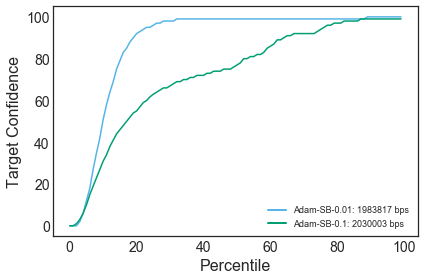

In [13]:
# high lr vs low lr with adam

plot_home_dir = "../plots/batch_stats"

group_name = "190222_lr"
exp_name = "adam"
group_plot_dir = "{}/{}".format(plot_home_dir, group_name)
if not os.path.exists(group_plot_dir):
        os.makedirs(group_plot_dir)
plot_dir = "{}/{}".format(group_plot_dir, exp_name)
if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

prefixes = ["../plots/batch_stats/190222_adam/data/"]
files = ["{}/{}".format(prefixes[0], "deterministic_cifar10_mobilenetv2_0.1_128_0.01_0_trial1_seed1337_target_confidences.pickle_epoch230_1983817backpropped.txt"),
         "{}/{}".format(prefixes[0], "deterministic_cifar10_mobilenetv2_0.1_128_0.1_0_trial1_seed1337_target_confidences.pickle_epoch110_2030003backpropped.txt")]
labels = ["Adam-SB-0.01: 1983817 bps",
          "Adam-SB-0.1: 2030003 bps" ]
colors = ["#56b4e9", "#009e73", "#0072b2", "#d55e00"]
plot_percentiles(plot_dir, files, labels, colors)

In [14]:
# high lr vs low lr with sgd

plot_home_dir = "../plots/batch_stats"

group_name = "190222_lr"
exp_name = "sgd"
group_plot_dir = "{}/{}".format(plot_home_dir, group_name)
if not os.path.exists(group_plot_dir):
        os.makedirs(group_plot_dir)
plot_dir = "{}/{}".format(group_plot_dir, exp_name)
if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

prefixes = ["../plots/batch_stats/190108_confidences_basic/data/"]
files = ["{}/{}".format(prefixes[0], "sampling_cifar10_mobilenetv2_0.1_128_0.0_0.0005_trial1_seed1337_target_confidences.pickle_epoch180_2479354backpropped.txt"),
         "{}/{}".format(prefixes[0], "sampling_cifar10_mobilenetv2_1_128_0.0_0.0005_trial1_seed1337_target_confidences.pickle_epoch50_2500000backpropped.txt"),
         "{}/{}".format(prefixes[0], "sampling_cifar10_mobilenetv2_0.1_128_0.0_0.0005_trial1_seed1337_target_confidences.pickle_epoch1420_13021238backpropped.txt"),
         "{}/{}".format(prefixes[0], "sampling_cifar10_mobilenetv2_1_128_0.0_0.0005_trial1_seed1337_target_confidences.pickle_epoch260_13000000backpropped.txt"),
        ]
labels = ["SB-LR0.1-2479354",
          "Baseline-LR0.1-2500000",
          "SB-LR0.01-13021238",
          "Baseline-LR0.01-13000000"]
colors = ["#56b4e9", "#009e73", "#0072b2", "#d55e00"]
plot_percentiles(plot_dir, files, labels, colors)

../plots/batch_stats/190222_lr/sgd/Target Confidence.pdf
../plots/batch_stats/190222_lr/sgd/Percent Correct.pdf


<Figure size 432x288 with 0 Axes>